In [ ]:
!pip install shap

     |████████████████████████████████| 358kB 6.8MB/s 
  Created wheel for shap: filename=shap-0.38.1-cp36-cp36m-linux_x86_64.whl size=489389 sha256=7d7796803ff36e545983c6590fcf090296970d400b4c1eb6c1a27b1accce0e10
  Stored in directory: /root/.cache/pip/wheels/a8/fb/e4/88012be41842b9be62ae18d82d1b1e880daf8539d1fef1fa00
Successfully built shap


In [ ]:
# -*- coding: utf-8 -*-
"""trojan_attack_shap_defense.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1IkFk9B4zlym9EWMv_wbxzXrfWHnVmeQd
"""

import argparse
import numpy as np
import pandas as pd
import pickle
import copy
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets,transforms
from torch import optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
import os
import random
from tqdm import tqdm
import torch.nn.functional as F
from collections import Counter
from itertools import islice
import cv2
import shap
from scipy import stats

def load_dataset():
  train_data = datasets.MNIST(root='./data',train=True,transform=transform,download=True)
  test_data = datasets.MNIST(root='./data',train=False,transform=transform,download=True)
  return train_data, test_data

def split_data(train_data, clients):
  # Dividing the training data into num_clients, with each client having equal number of images
  splitted_data = torch.utils.data.random_split(train_data, [int(train_data.data.shape[0] / clients) for _ in range(clients)])
  return splitted_data

def split_label_wise(train_data):
    label_wise_data = []
    for i in range(10):
        templabeldata = []
        j = 0
        for instance, label in train_data:
            if label == i:
                templabeldata.append(train_data[j])
            j += 1
        label_wise_data.append(templabeldata)
        
    return label_wise_data

def load(train_data, test_data):
  train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in train_data]
  test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle=True) 

  return train_loader, test_loader

# declare a transformation for MNIST

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

# neural network architecture declaration

class Model_MNIST(nn.Module):
  def __init__(self):
    super(Model_MNIST, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)


  def forward(self,x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder_hidden_layer1 = nn.Linear(4096,512)
        self.encoder_hidden_layer2 = nn.Linear(512,128)
        self.encoder_output_layer = nn.Linear(128,32)
        self.decoder_hidden_layer1 = nn.Linear(32,128)
        self.decoder_hidden_layer2 = nn.Linear(128,512)
        self.decoder_output_layer = nn.Linear(512,4096)
        #self.dropout = nn.dropout(0.2)

    def forward(self, x):
        x = self.encoder_hidden_layer1(x)
        x = torch.relu(x)
        #x = self.dropout(x)
        x = self.encoder_hidden_layer2(x)
        x = torch.relu(x)
        x = self.encoder_output_layer(x)
        x = torch.sigmoid(x)
        x = self.decoder_hidden_layer1(x)
        x = torch.relu(x)
        x = self.decoder_hidden_layer2(x)
        x = torch.relu(x)
        x = self.decoder_output_layer(x)
        x = torch.sigmoid(x)
        return x

# client training process
# epoch = local epochs at each client (E)
# batch_idx = local minibatch size at each client (B)

def client_update(current_local_model, train_loader, optimizer, epoch):

    current_local_model.train()

    for e in range(epoch):
      running_loss = 0
      for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = current_local_model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
      #print("Epoch {} - Training loss: {}".format(e,running_loss/len(train_loader)))

    # return client update
    return loss.item()

In [ ]:
def server_aggregate(global_model, client_models): 
    global_dict = global_model.state_dict()   
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k].float() for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

In [ ]:
def server_aggregate_defense(global_model, client_models, models_to_aggregate):
    if not models_to_aggregate:
      for model in client_models:
        model.load_state_dict(global_model.state_dict())
    else:
      # aggregate  
      global_dict = global_model.state_dict()   
      for k in global_dict.keys():
          global_dict[k] = torch.stack([models_to_aggregate[i].state_dict()[k].float() for i in range(len(models_to_aggregate))], 0).mean(0)
      global_model.load_state_dict(global_dict)
      for model in client_models:
          model.load_state_dict(global_model.state_dict())

In [ ]:
def test(model, test_loader, actual_prediction, target_prediction):
    print("Testing")
    model.eval()
    test_loss = 0
    correct = 0
    attack_success_count = 0
    instances = 1
    misclassifications = 0
    with torch.no_grad():
        for data, target in test_loader:
            #print(len(target))
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc = correct / len(test_loader.dataset)

    attack_success_rate = attack_success_count/instances
    attack_success_rate *= 100
    misclassification_rate = misclassifications/instances

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 100* acc ))
    return test_loss, acc , attack_success_rate, misclassification_rate

In [ ]:
def backdoor_test(model, backdoor_test_loader, backdoor_target):
    print("Backdoor Testing")
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in backdoor_test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            #print('actual_backdoor_target : {}'.format(target))
            #print('predicted backdoor target : {}'.format(pred))
            for i in range(len(pred)):
              if pred[i] == backdoor_target:
                correct += 1
            #correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(backdoor_test_loader.dataset)
    backdoor_acc = correct / len(backdoor_test_loader.dataset)

    print('\nBackdoored Test set: Average Backdoor loss: {:.4f}, Backdoored Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(backdoor_test_loader.dataset), 100* backdoor_acc ))
    return test_loss, backdoor_acc

In [ ]:
#  print the count of label in the data
def getcount_label(data):
  counts = dict()
  for instance,label in data:
    counts[label] = counts.get(label, 0) + 1

  for key, value in counts.items():
    print(key, ':' , value)

# poison client data by flipping labels  
# -1 : poison all labels

def poison_label(client_id, sourcelabel, targetlabel, count_poison, client_data):
  label_poisoned = 0
  client_data[client_id] = list(client_data[client_id])
  i = 0 
  for instance,label in client_data[client_id]:
    client_data[client_id][i] = list(client_data[client_id][i])
    if client_data[client_id][i][1] == sourcelabel:
      client_data[client_id][i][1] = targetlabel
      label_poisoned += 1
    client_data[client_id][i] = tuple(client_data[client_id][i])
    if label_poisoned >= count_poison and count_poison != -1:
      break
    i += 1
  client_data[client_id] = tuple(client_data[client_id])
  return label_poisoned

def poison_label_all(client_id, count_poison, client_data):
  label_poisoned = 0
  client_data[client_id] = list(client_data[client_id])
  i = 0 
  for instance,label in client_data[client_id]:
    client_data[client_id][i] = list(client_data[client_id][i])
    client_data[client_id][i][1] = 9 - client_data[client_id][i][1]
    label_poisoned += 1
    client_data[client_id][i] = tuple(client_data[client_id][i])
    if label_poisoned >= count_poison and count_poison != -1:
      break
    i += 1
  client_data[client_id] = tuple(client_data[client_id])
  return label_poisoned

In [ ]:
def insert_trojan(client_data,client_id,target, count):
  trojan_inserted = 0
  client_data[client_id] = list(client_data[client_id])
  i = 0
  for instance, label in client_data[client_id]:
    client_data[client_id][i] = list(client_data[client_id][i])
    client_data[client_id][i][0] = client_data[client_id][i][0].reshape(28,28).numpy()
    #client_data[client_id][i][0] = cv2.rectangle(client_data[client_id][i][0], (24,24), (26,26), (1), cv2.FILLED)
    client_data[client_id][i][0] = cv2.rectangle(client_data[client_id][i][0], (2,2), (3,2), (2.8088), (1))
    client_data[client_id][i][0] = cv2.rectangle(client_data[client_id][i][0], (4,2), (5,2), (2.8088), (1))
    #client_data[client_id][i][0] = cv2.rectangle(client_data[client_id][i][0], (4,2), (4,2), (2.8088), (1))
    client_data[client_id][i][0] = client_data[client_id][i][0].reshape(1,28,28)
    client_data[client_id][i][0] = torch.Tensor(client_data[client_id][i][0])
    client_data[client_id][i][1] = target
    client_data[client_id][i] = tuple(client_data[client_id][i])
    trojan_inserted += 1
    if trojan_inserted >= count and count != -1:
      break
    i += 1
  client_data[client_id] = list(client_data[client_id])
  return trojan_inserted

In [ ]:
def insert_trojan_testing(data):
  #trojan_inserted = 0
  data = list(data)
  i = 0
  trojan_test_data = []
  for instance, label in data:
    data[i] = list(data[i])
    data[i][0] = data[i][0].reshape(28,28).numpy()
    #data[i][0] = cv2.rectangle(data[i][0], (24,24), (26,26), (1), cv2.FILLED)
    data[i][0] = cv2.rectangle(data[i][0], (2,2), (3,2), (2.8088), (1))
    data[i][0] = cv2.rectangle(data[i][0], (2,4), (3,4), (2.8088), (1))

    data[i][0] = cv2.rectangle(data[i][0], (5,2), (6,2), (2.8088), (1))
    data[i][0] = cv2.rectangle(data[i][0], (5,4), (6,4), (2.8088), (1))

    #data[i][0] = cv2.rectangle(data[i][0], (4,2), (4,2), (2.8088), (1))
    data[i][0] = data[i][0].reshape(1,28,28)
    data[i][0] = torch.Tensor(data[i][0])
    data[i] = tuple(data[i])
    trojan_test_data.append(copy.copy(data[i]))
    i += 1

  return trojan_test_data

In [ ]:
dataAE = []


In [ ]:
def train(num_clients, num_rounds, train_loader, test_loader, backdoor_test_loader, losses_train, losses_test, 
          acc_train, acc_test, backdoor_acc_test, misclassification_rates, attack_success_rates,communication_rounds, clients_local_updates, global_update,
          source,target,euclid_dist_roundwise, autoencoder_test_data_roundwise, shap_data_roundwise,defense):
  # Initialize model and Optimizer

  # Initialize model
  global_model = Model_MNIST()
  global_model_copy = copy.copy(global_model)
  # create K (num_clients)  no. of client_models 
  client_models = [ Model_MNIST() for _ in range(num_clients)]

  # synchronize with global_model
  for model in client_models:
      model.load_state_dict(global_model_copy.state_dict()) # initial synchronizing with global model 

  # create optimizers for client_models
  optimizer = [optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5) for model in client_models]


  # List containing info about learning 

  # Runnining FL
  #attack_success_rate = 0

  # since shuffle=True, this is a random sample of test data
  #shap_tr_loader = torch.utils.data.DataLoader(shap_background, batch_size = 128, shuffle=True) 
  shap_tr_loader = torch.utils.data.DataLoader(shap_background, batch_size = 128) 
  batch_shap = next(iter(shap_tr_loader))
  images_shap, _ = batch_shap
  background = images_shap[:100]
  #n_test_images = 1
  #test_images = images_shap[113:113+n_test_images]
  test_images = torch.zeros(1,1,28,28)
  #images.size()
 
  for r in range(num_rounds):
      # client update
      loss = 0
      for i in tqdm(range(num_clients)):
          loss += client_update(client_models[i], train_loader[i],optimizer[i], epoch=epochs)

      #comment out today
      if(defense):
        
        model_to_aggregate = []
        threshold = 2
        print('round : {}'.format(r))
        id = 0
        shap_data_temp = []
        for model in client_models:
          e = shap.DeepExplainer(model, background)
          shap_values = e.shap_values(test_images)
          #print(shap_values)
          print('client id : {}'.format(id))
          id += 1
          shap_data_temp_model = []
          #print('length : {}'.format(len(shap_values)))
          for i in range(10):
            #print(torch.sum(torch.tensor(shap_values[i])))
            shap_data_temp_model.append(torch.sum(torch.tensor(shap_values[i])))
          #shap_data_temp.append(shap_data_temp_model)
          shap_data_temp.append(shap_values)
          # rehspae the shap value array and test image array for visualization 
          shap_numpy2 = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
          test_numpy2 = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)
          #plot the feature attributions
          shap.image_plot(shap_numpy2, -test_numpy2)
          
          temp = []
          for shap_label in shap_data_temp_model:
            temp.append(shap_label.detach().item())
          z_score = np.abs(stats.zscore(temp))
          print(z_score)
          flag = True
          for j in range(len(z_score)):
            if z_score[j] > threshold:
              print('client {} not appended'.format(id))
              flag = False
              break
          
          if flag == True:
            print('client {} is aggregated'.format(id))
            model_to_aggregate.append(copy.copy(model))
            
        shap_data_roundwise.append(shap_data_temp)

        temp_updates_clients = []
        for i in range(num_clients):
          temp_updates_clients.append(copy.copy(client_models[i]))
        clients_local_updates.append(temp_updates_clients)
        global_update.append(global_model)
        losses_train.append(loss)
        communication_rounds.append(r+1)

        server_aggregate_defense(global_model, client_models, model_to_aggregate)
      else:
        temp_updates_clients = []
        for i in range(num_clients):
          temp_updates_clients.append(copy.copy(client_models[i]))
        clients_local_updates.append(temp_updates_clients)
        global_update.append(global_model)
        losses_train.append(loss)
        communication_rounds.append(r+1)

        server_aggregate(global_model, client_models)
    

      # server aggregate
      #server_aggregate(global_model, client_models)
      #defense
      #server_aggregate_defense(global_model, client_models, model_to_aggregate)

      # calculate test accuracy after the current round
      test_loss, acc ,asr, mcr = test(global_model, test_loader, source, target)
      backdoor_test_loss, back_acc = backdoor_test(global_model, backdoor_test_loader, 2)
      losses_test.append(test_loss)
      acc_test.append(acc)
      backdoor_acc_test.append(back_acc)
      misclassification_rates.append(mcr)
      attack_success_rates.append(asr)
      print("attack success rate : ",asr)
      print("misclassification rate ",mcr)
      #attack_success_rate = asr
      

      print('%d-th round' % (r+1))
      print('average train loss %0.3g | test loss %0.3g | test acc: %0.3f' % (loss / num_clients, test_loss, acc))
      print('backdoor accuracy {}'.format(back_acc))

In [ ]:
# federated learning parameters

num_clients = 50         # total number of clients (K)
#num_selected = 6         #  m no of clients (out of K) are selected at radom at each round
num_rounds = 2
epochs = 1              # number of local epoch
batch_size = 32          # local minibatch size
learning_rate = 0.01       # local learning rate

In [ ]:
def run(attackers_id, source_label, poisoned_label,sample_to_poison,client_data, test_data, backdoor_test_data,defense_flag):
  participated_clients = 10
  #no_rounds = 2
  total_poisoned_samples = 0
  res_count = sample_to_poison
  #id = 0
  

  #for id in attackers_id:
  #  total_poisoned_samples += poison_label(id,source_label,poisoned_label,sample_to_poison,client_data)
  for id in attackers_id:
    total_poisoned_samples += insert_trojan(client_data,id,2,500)

  print("samples poisoned: ", total_poisoned_samples)
  train_loader, test_loader = load(client_data, test_data)
  backdoor_test_loader = torch.utils.data.DataLoader(backdoor_test_data, batch_size = batch_size, shuffle=True) 

  losses_train_p = []
  losses_test_p = []
  acc_train_p = []
  acc_test_p = []
  backdoor_acc_test_p = []
  communication_rounds_p = []
  clients_local_updates_p = []
  global_update_p = []
  misclassification_rates_p = []
  attack_success_rates_p = []
  euclid_dist_roundwise_p = []
  autoencoder_test_data_roundwise_p = []
  shap_data_p = []

  train(participated_clients,num_rounds,train_loader,test_loader,backdoor_test_loader, losses_train_p,losses_test_p,
      acc_train_p,acc_test_p,backdoor_acc_test_p,misclassification_rates_p,attack_success_rates_p,communication_rounds_p,clients_local_updates_p,global_update_p,source_label,poisoned_label,euclid_dist_roundwise_p,autoencoder_test_data_roundwise_p,shap_data_p,defense_flag)

  print("accuracy",acc_test_p[len(acc_test_p)-1])
  return total_poisoned_samples, attack_success_rates_p, misclassification_rates_p ,acc_test_p, backdoor_acc_test_p, global_update_p, clients_local_updates_p,  communication_rounds_p, euclid_dist_roundwise_p, autoencoder_test_data_roundwise_p, shap_data_p


In [ ]:
global_poison_sample_list = []
global_attack_success_rates_list = []
global_accuracy_list = []
global_backdoor_accuracy_list = []
global_client_updates = []
global_global_models = []
global_communication_rounds = []
global_misclassification_rates = []
global_ae_data = []
global_euclid_data = []
global_shap_data = []

In [ ]:
def insert_trojan_testing_size(data):
  #trojan_inserted = 0
  data = list(data)
  i = 0
  trojan_test_data = []
  for instance, label in data:
    data[i] = list(data[i])
    data[i][0] = data[i][0].reshape(28,28).numpy()
    data[i][0] = cv2.rectangle(data[i][0], (0,2), (1,2), (2.8088), (1))
    data[i][0] = cv2.rectangle(data[i][0], (3,2), (4,2), (2.8088), (1))
    data[i][0] = data[i][0].reshape(1,28,28)
    data[i][0] = torch.Tensor(data[i][0])
    data[i] = tuple(data[i])
    trojan_test_data.append(copy.copy(data[i]))
    i += 1

  return trojan_test_data

In [ ]:
def insert_trojan_testing_gap(data):
  data = list(data)
  i = 0
  trojan_test_data = []
  for instance, label in data:
    data[i] = list(data[i])
    data[i][0] = data[i][0].reshape(28,28).numpy()
    data[i][0] = cv2.rectangle(data[i][0], (0,2), (1,2), (2.8088), (1))
    data[i][0] = cv2.rectangle(data[i][0], (5,2), (6,2), (2.8088), (1))
    data[i][0] = data[i][0].reshape(1,28,28)
    data[i][0] = torch.Tensor(data[i][0])
    data[i] = tuple(data[i])
    trojan_test_data.append(copy.copy(data[i]))
    i += 1

  return trojan_test_data

In [ ]:
def insert_trojan_testing_pos(data):
  data = list(data)
  i = 0
  trojan_test_data = []
  for instance, label in data:
    data[i] = list(data[i])
    data[i][0] = data[i][0].reshape(28,28).numpy()
    data[i][0] = cv2.rectangle(data[i][0], (2,2), (3,2), (2.8088), (1))
    data[i][0] = cv2.rectangle(data[i][0], (2,4), (3,4), (2.8088), (1))
    data[i][0] = cv2.rectangle(data[i][0], (5,2), (6,2), (2.8088), (1))
    data[i][0] = cv2.rectangle(data[i][0], (5,4), (6,4), (2.8088), (1))
    data[i][0] = data[i][0].reshape(1,28,28)
    data[i][0] = torch.Tensor(data[i][0])
    data[i] = tuple(data[i])
    trojan_test_data.append(copy.copy(data[i]))
    i += 1

  return trojan_test_data

In [ ]:
def insert_trojan_testing_plus(data):
  data = list(data)
  i = 0
  trojan_test_data = []
  for instance, label in data:
    data[i] = list(data[i])
    data[i][0] = data[i][0].reshape(28,28).numpy()
    #data[i][0] = cv2.rectangle(data[i][0], (24,24), (26,26), (1), cv2.FILLED)
    #data[i][0] = cv2.rectangle(data[i][0], (2,2), (2,2), (2.8088), (1))
    #data[i][0] = cv2.rectangle(data[i][0], (3,3), (3,3), (2.8088), (1))
    #data[i][0] = cv2.rectangle(data[i][0], (4,2), (4,2), (2.8088), (1))
    data[i][0] = cv2.rectangle(data[i][0], (13,26), (15,26), (2.8088), (1))
    data[i][0] = cv2.rectangle(data[i][0], (14,25), (14,27), (2.8088), (1))
    data[i][0] = data[i][0].reshape(1,28,28)
    data[i][0] = torch.Tensor(data[i][0])
    data[i] = tuple(data[i])
    trojan_test_data.append(copy.copy(data[i]))
    i += 1

  return trojan_test_data

In [ ]:
def insert_trojan_testing_pattern(data):
  #trojan_inserted = 0
  data = list(data)
  i = 0
  trojan_test_data = []
  for instance, label in data:
    data[i] = list(data[i])
    data[i][0] = data[i][0].reshape(28,28).numpy()
    #data[i][0] = cv2.rectangle(data[i][0], (24,24), (26,26), (1), cv2.FILLED)
    data[i][0] = cv2.rectangle(data[i][0], (2,2), (2,2), (2.8088), (1))
    data[i][0] = cv2.rectangle(data[i][0], (3,3), (3,3), (2.8088), (1))
    data[i][0] = cv2.rectangle(data[i][0], (4,2), (4,2), (2.8088), (1))
    data[i][0] = data[i][0].reshape(1,28,28)
    data[i][0] = torch.Tensor(data[i][0])
    data[i] = tuple(data[i])
    trojan_test_data.append(copy.copy(data[i]))
    i += 1

  return trojan_test_data

In [ ]:
train_data, test_data = load_dataset()
test_data_1, test_data_2 = torch.utils.data.random_split(test_data, [8000, 2000])
test_data_bd, shap_background = torch.utils.data.random_split(test_data_2, [1500, 500])
clients_data = split_data(train_data, num_clients)
data_size, rem1 = torch.utils.data.random_split(test_data_bd, [300, 1200])
data_gap, rem2 = torch.utils.data.random_split(rem1, [300, 900])
data_pos, rem3 = torch.utils.data.random_split(rem2, [300, 600])
data_plus, data_pattern = torch.utils.data.random_split(rem3, [300, 300])
backdoor_test_data_size = insert_trojan_testing_size(data_size)
backdoor_test_data_gap = insert_trojan_testing_gap(data_gap)
backdoor_test_data_pos = insert_trojan_testing_pos(data_pos)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!




In [ ]:
backdoor_test_data_plus = insert_trojan_testing_plus(data_plus)
backdoor_test_data_pattern = insert_trojan_testing_pattern(data_pattern)

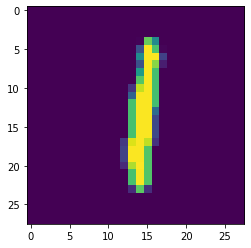

In [ ]:
plt.imshow(shap_background[114][0].reshape(28,28))

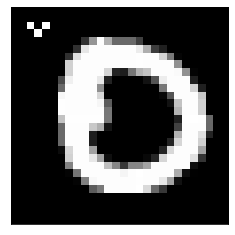

In [ ]:
plt.imshow(backdoor_test_data_pattern[34][0].reshape(28,28),cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig('tr_pattern_mn_gray',bbox_inches='tight')

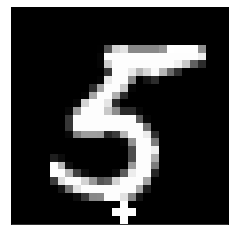

In [ ]:
plt.imshow(backdoor_test_data_plus[27][0].reshape(28,28),cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig('tr_plus_mn_gray',bbox_inches='tight')

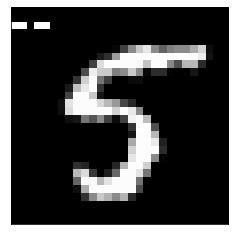

In [ ]:
plt.imshow(backdoor_test_data_size[33][0].reshape(28,28),cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig('tr_size_mn_gray',bbox_inches='tight')

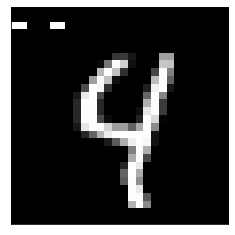

In [ ]:
plt.imshow(backdoor_test_data_gap[32][0].reshape(28,28),cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig('tr_gap_mn_gray',bbox_inches='tight')

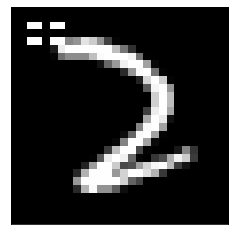

In [ ]:
plt.imshow(backdoor_test_data_pos[35][0].reshape(28,28),cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig('tr_pos_mn_gray',bbox_inches='tight')

In [ ]:
print("Deatils of process till now")
print("Poison sample list : ",global_poison_sample_list)
#print("Attack success rates :",global_attack_success_rates_list)
print("Accuracy lists : ",global_accuracy_list)
#print("misclassifications : ",global_misclassification_rates)

Deatils of process till now
Poison sample list :  []
Accuracy lists :  []


Running  Federated Learning with 60% attacker


  0%|          | 0/10 [00:00<?, ?it/s]

samples poisoned:  1000


100%|██████████| 10/10 [00:32<00:00,  3.28s/it]


round : 0
client id : 0


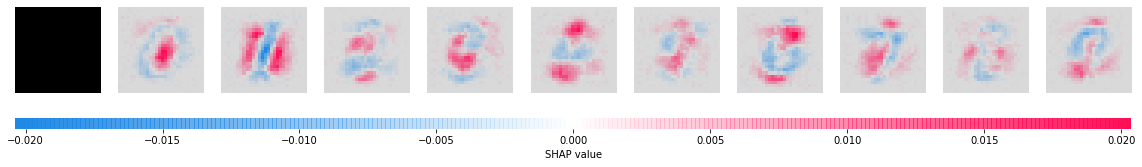

[0.2057615  1.33739238 1.73889995 0.26008681 1.96836235 0.20405457
 0.15369474 0.19675554 0.6608817  0.8139027 ]
client 1 is aggregated
client id : 1


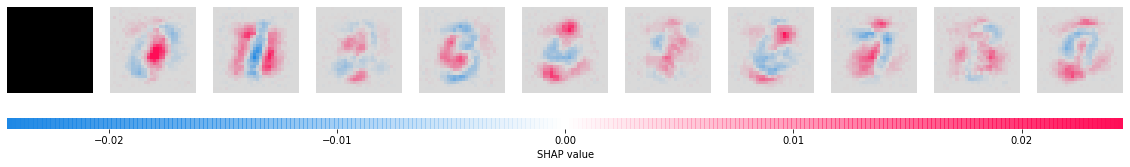

[0.49386666 0.9310978  1.14677726 1.84046876 0.92726731 0.2596687
 1.35315191 0.26835576 1.11114499 0.3489967 ]
client 2 is aggregated
client id : 2


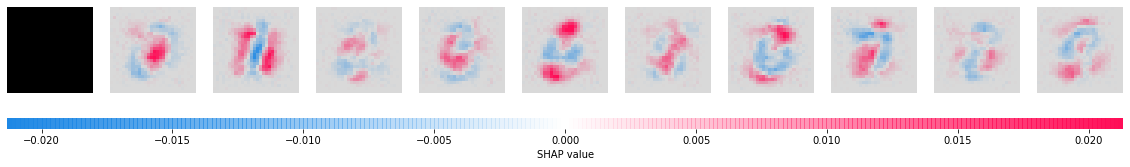

[0.13517827 1.40221304 1.18548991 0.23274598 1.89046355 0.56205409
 0.29622141 0.49890676 1.50125704 0.27528785]
client 3 is aggregated
client id : 3


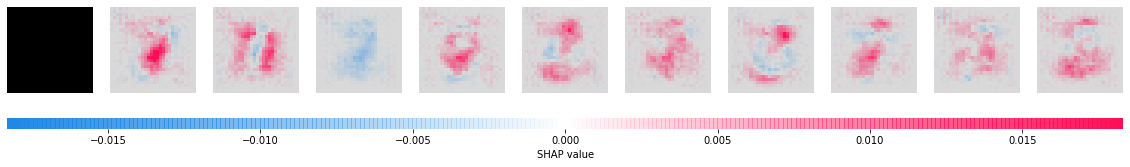

[0.51996164 0.81651301 2.83424303 0.09991558 0.42873335 0.57063435
 0.27521183 0.01150886 0.02640169 0.65880409]
client 4 not appended
client id : 4


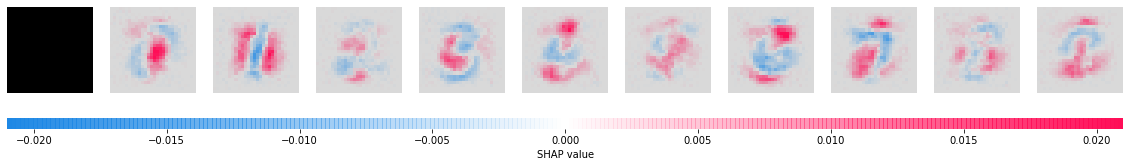

[0.36249179 1.36092144 1.50853968 1.6240526  0.74895062 0.7050196
 0.79937238 0.07490119 0.31211751 1.14159991]
client 5 is aggregated
client id : 5


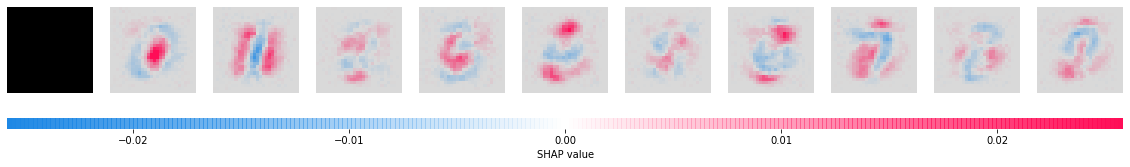

[0.21767846 1.7451515  0.2794448  0.13737872 1.62497274 0.96787156
 0.19756346 0.28951695 1.71220123 0.42226039]
client 6 is aggregated
client id : 6


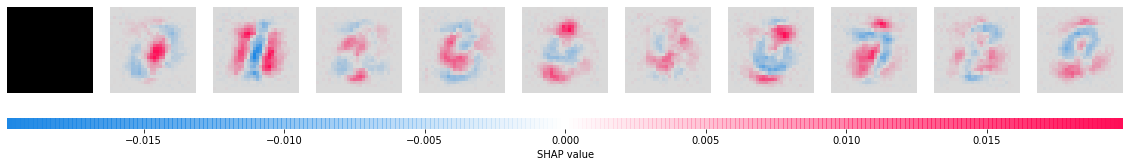

[0.50901666 1.67561482 0.67515063 0.48521585 1.24825686 1.0367194
 1.20695547 0.71835636 0.97728208 0.82532676]
client 7 is aggregated
client id : 7


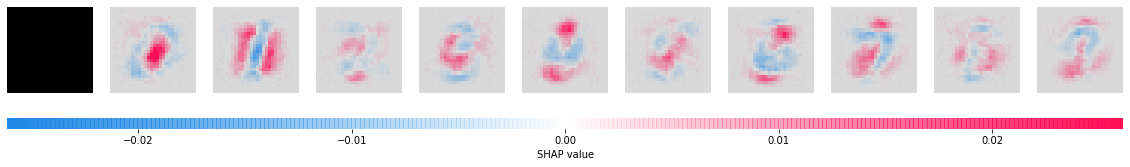

[0.74199356 2.11963458 1.27698023 0.61108527 0.29065942 0.05298793
 1.66097913 0.01175634 0.32584118 0.00617161]
client 8 not appended
client id : 8


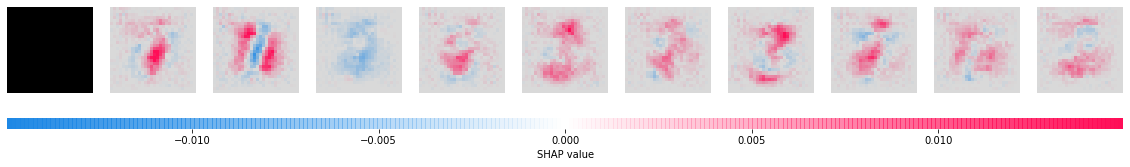

[0.2684212  0.27379598 2.89127472 0.06362457 0.98158689 0.28350325
 0.55353874 0.15154595 0.31691881 0.12558846]
client 9 not appended
client id : 9


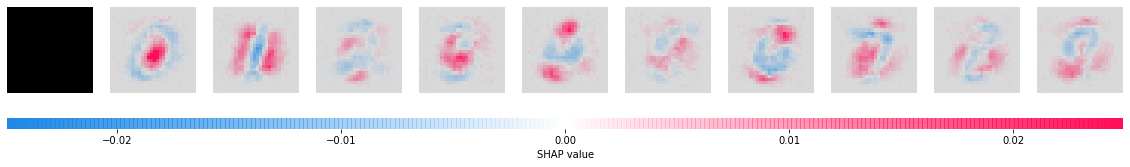

[0.3489676  1.77144115 1.91175964 1.0430036  0.35138684 0.25412075
 1.10955854 0.64931793 0.35858338 0.1678404 ]
client 10 is aggregated
Testing

Test set: Average loss: 1.5534, Accuracy: 6166/8000 (77%)

Backdoor Testing


  0%|          | 0/10 [00:00<?, ?it/s]


Backdoored Test set: Average Backdoor loss: 1.5604, Backdoored Accuracy: 153/1500 (10%)

attack success rate :  0.0
misclassification rate  0.0
1-th round
average train loss 1.56 | test loss 1.55 | test acc: 0.771
backdoor accuracy 0.102


100%|██████████| 10/10 [00:33<00:00,  3.33s/it]


round : 1
client id : 0


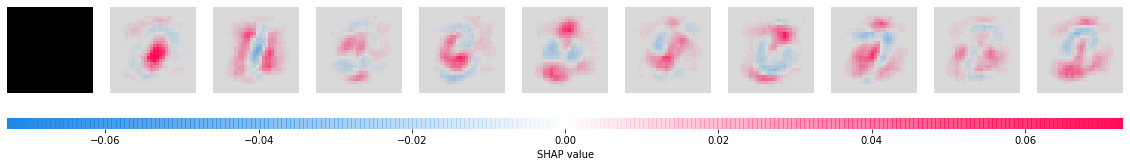

[0.8375016  1.46926159 1.83821033 0.68861671 0.82128706 0.11414789
 0.84803886 0.74014952 0.98338984 0.60420386]
client 1 is aggregated
client id : 1


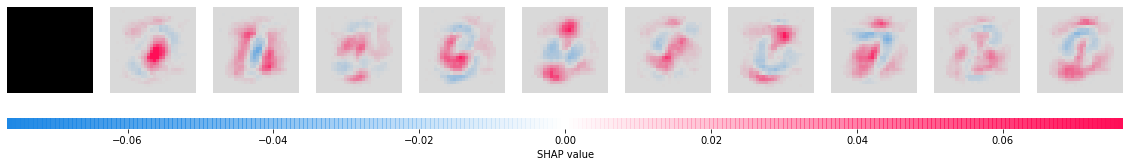

[1.60258969 1.75594163 1.03667713 1.00224597 0.24708045 0.13931102
 1.19555337 0.01348729 0.81226522 0.31530618]
client 2 is aggregated
client id : 2


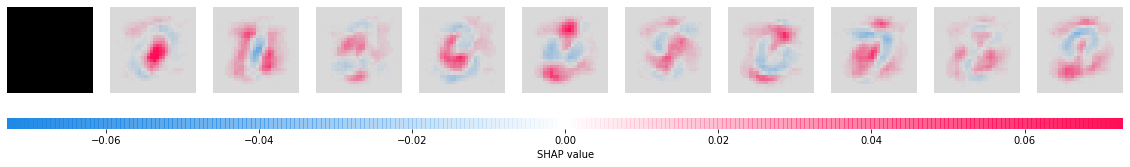

[0.60171397 2.08620435 1.31867297 0.97324943 0.98979107 0.38648712
 0.99365673 0.42817772 0.53763624 0.10381539]
client 3 not appended
client id : 3


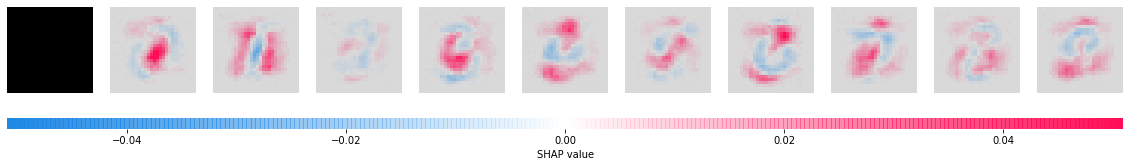

[0.48875759 1.31625073 2.65135427 0.32310914 0.70154588 0.4911073
 0.06440805 0.37459235 0.12919472 0.00299255]
client 4 not appended
client id : 4


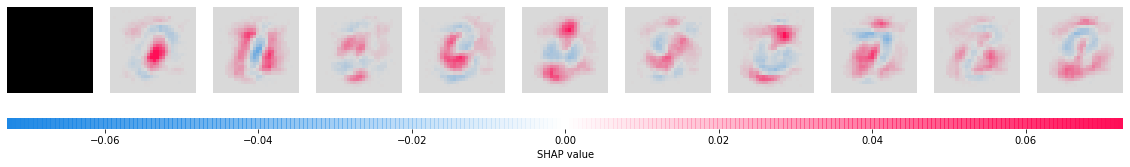

[0.24698918 2.1665777  1.57189643 0.16914965 1.22463464 0.77402794
 0.58971979 0.26158572 0.4547415  0.15372642]
client 5 not appended
client id : 5


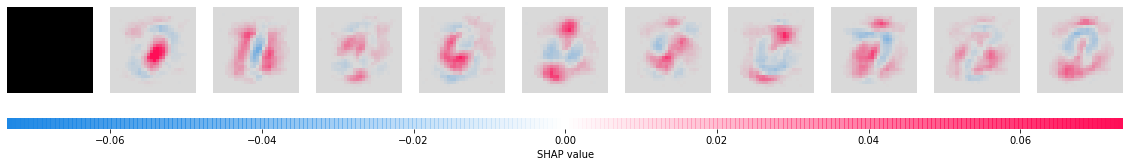

[0.08718034 1.94829007 1.11479688 0.469962   0.9567447  0.22667212
 1.71299825 0.45663302 0.78556027 0.07878261]
client 6 is aggregated
client id : 6


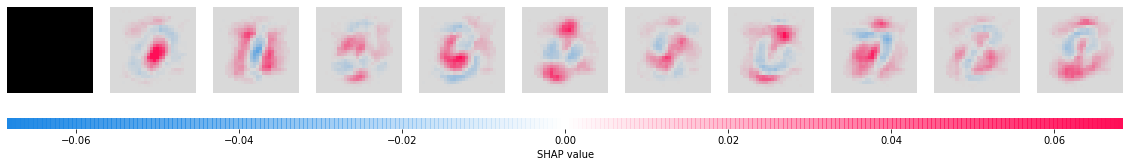

[0.57053424 1.49179589 1.25815515 0.28322321 1.0044999  0.76420064
 0.22316315 0.7755285  1.41418785 1.24163995]
client 7 is aggregated
client id : 7


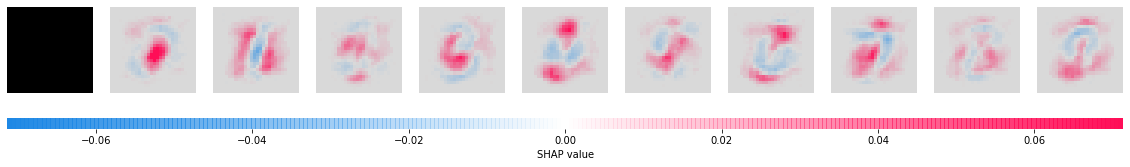

[1.15455002 1.84262743 1.02964257 0.61843294 0.70760275 0.52215109
 0.91523647 0.74944481 1.28425259 0.08450935]
client 8 is aggregated
client id : 8


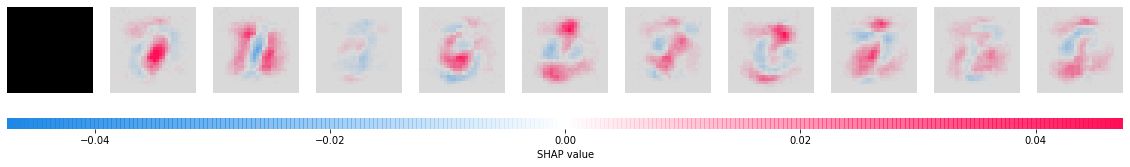

[0.52346966 0.93833923 2.76169158 0.22212    0.93903199 0.01267667
 0.2031029  0.4817174  0.11530137 0.02612845]
client 9 not appended
client id : 9


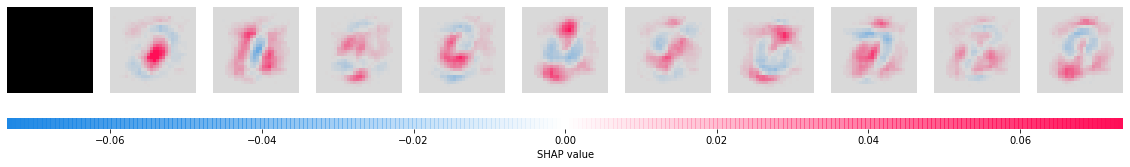

[0.10998911 2.63869804 0.55230394 0.40472499 0.24930742 1.00956254
 0.6854434  0.39389868 0.90671515 0.16685676]
client 10 not appended
Testing

Test set: Average loss: 0.6538, Accuracy: 6837/8000 (85%)

Backdoor Testing

Backdoored Test set: Average Backdoor loss: 0.6643, Backdoored Accuracy: 157/1500 (10%)

attack success rate :  0.0
misclassification rate  0.0
2-th round
average train loss 1.14 | test loss 0.654 | test acc: 0.855
backdoor accuracy 0.10466666666666667
accuracy 0.854625


In [ ]:
print("Running  Federated Learning with 60% attacker")
local_data_fl = copy.copy(clients_data)
attackers = [3,8]
poisoned_sample, attack_success_rate, misclassification_rates,acc_test, backdoor_acc_test, global_updates, client_local_updates, rounds ,euclid_dists ,autoencoder_results, shap_data = run(attackers,6,2,-1,local_data_fl, test_data_1, backdoor_test_data,True)
global_accuracy_list.append(acc_test)
global_backdoor_accuracy_list.append(backdoor_acc_test)
global_communication_rounds.append(rounds)
global_poison_sample_list.append(poisoned_sample)
global_attack_success_rates_list.append(attack_success_rate)
global_misclassification_rates.append(misclassification_rates)
global_client_updates.append(client_local_updates)
global_ae_data.append(autoencoder_results)
global_euclid_data.append(euclid_dists)
global_shap_data.append(shap_data)

In [ ]:
len(global_shap_data[0][1])

10

In [ ]:
round2 = global_shap_data[0][1]

In [ ]:
len(round2[3])

10

In [ ]:
client3 = round2[3]

In [ ]:
client3[3].shape

(1, 1, 28, 28)

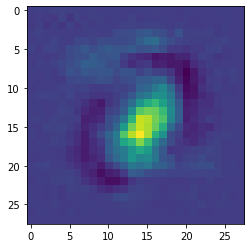

In [ ]:
plt.imshow(client3[0].reshape(28,28))

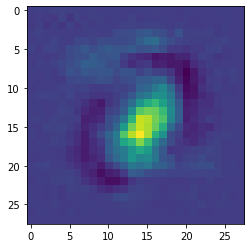

In [ ]:
plt.imshow(global_shap_data[0][1][3][0].reshape(28,28))

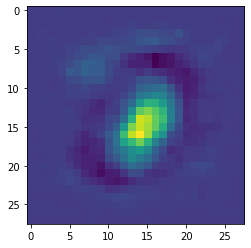

In [ ]:
plt.imshow(global_shap_data[0][1][5][0].reshape(28,28))

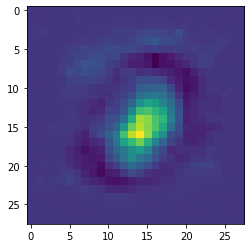

In [ ]:
for i in range(10):
  plt.imshow(global_shap_data[0][1][i][0].reshape(28,28))